In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install moviepy
!pip install pysdl2
!pip install pyvirtualdisplay

In [ ]:
!pip install opencv-python

In [2]:
import gymnasium as gym
import random 
import torch
import numpy as np
from torch import nn
from torch.distributions import Categorical

from gymnasium import wrappers
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

In [3]:
#gym.envs.registration.registry.keys()

In [4]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
# record the game as as an mp4 file
env = wrappers.RecordVideo(env, video_folder='video/pong-base', episode_trigger=lambda n: n%200==0)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/opt/conda/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/chgaw002/DeepLearning/video/pong-base folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
from collections import deque
import cv2
cv2.ocl.setUseOpenCL(False)


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        ob, info = self.env.reset(**kwargs)
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done = True
        self.was_real_reset = False

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
            self.was_real_reset = True
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, info = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info
    
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs, info = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs, info

    

In [7]:
def make_env(env, stack_frames=True, episodic_life=True):
    if episodic_life:
        env = EpisodicLifeEnv(env)

    env = MaxAndSkipEnv(env, skip=4)

    env = WarpFrame(env)
    if stack_frames:
        env = FrameStack(env, 4)
  
    return env


In [8]:
env = make_env(env)

In [9]:
def render(env):
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

class ActorCritic(nn.Module):
 
    def __init__(self, in_channels=4, n_actions=14):
        """
        Initialize Actor Network
        Args:
            in_channels (int): number of input channels
            n_actions (int): number of outputs
        """
        super(ActorCritic, self).__init__()
        self.actor_features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 256),
            nn.ReLU()
        )
        self.critic_features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 256),
            nn.ReLU()
        )
        self.actor_head = nn.Linear(256, n_actions)
        self.critic_head = nn.Linear(256, 1)
        
    def forward(self, x):
        x = x.float() / 255
        x_a = self.actor_features(x)
        x_c = self.critic_features(x)
        return F.softmax(self.actor_head(x_a), dim=-1), self.critic_head(x_c)

In [19]:
from collections import namedtuple
import random

SavedAction = namedtuple('SavedAction', 
                        ('log_prob', 'value'))


In [20]:
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorCriticPolicy:
    
    GAMMA = 0.99
    EPS = 1e-7
    RENDER = False
    # NOOP, UP, DOWN
    ACTIONS = [ 0, 2, 3 ]

    
    def __init__(self, lr=1e-4):
        self.n_actions = len(ActorCriticPolicy.ACTIONS)
        self.steps_done = 0
        self.mean_reward = None
        self.model = ActorCritic(n_actions=self.n_actions).to(device)
        self.saved_actions = []
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.postfix = {}
        
    def get_state(self, obs):
        state = np.array(obs)
        state = state.transpose((2, 0, 1))
        state = torch.from_numpy(state)
        return state.unsqueeze(0).to(device)

    def __call__(self, observation):
        state = self.get_state(observation)
        probs, value = self.model(state)
        
        m = Categorical(probs)
        action = m.sample()
        
        self.saved_actions.append(SavedAction(m.log_prob(action), value))
        self.steps_done += 1
        
        return ActorCriticPolicy.ACTIONS[action.item()]
  
        
    def init_game(self, observation):
        self.state = self.get_state(observation)
        self.total_reward = 0.0
        self.rewards = []
    
    def update(self, obs, reward, terminated, truncated, info, pbar):
        self.total_reward += reward
        self.rewards.append(reward)
        if not terminated:
            self.next_state = self.get_state(obs)
        else:
            if self.mean_reward is None:
                self.mean_reward = self.total_reward
            else:
                self.mean_reward = self.mean_reward * 0.95 + self.total_reward * (1.0 - 0.95)
            self.postfix['total_reward'] = self.total_reward
            self.postfix['mean_reward'] = self.mean_reward
            self.postfix['steps'] = self.steps_done
            pbar.set_postfix(self.postfix)
            self.next_state = None
            
            self.finish_episode()    
            
        if self.steps_done % 100_000 == 0:
            self.save(f'model_{self.steps_done}.pt')

    def finish_episode(self):
        R = 0
        policy_losses = []
        value_losses = []
        returns = []
        
        for r in self.rewards[::-1]:
            if r != 0:
                # Game boundary (Pong specific) !
                R = 0
            R = r + ActorCriticPolicy.GAMMA * R
            returns.insert(0, R)
            
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + ActorCriticPolicy.EPS)
        
        for (log_prob, value), R in zip(self.saved_actions, returns):
            advantage = R - value.item()

            # calculate actor (policy) loss
            policy_losses.append(-log_prob * advantage)

            # calculate critic (value) loss using L1 smooth loss
            value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).unsqueeze(0).to(device)))
            
        self.optimizer.zero_grad()
        # sum up all the values of policy_losses and value_losses
        policy_loss = torch.stack(policy_losses).sum()
        value_loss = torch.stack(value_losses).sum()
        loss = policy_loss + value_loss
        
        self.postfix['policy_loss'] = policy_loss.item()
        self.postfix['value_loss'] = value_loss.item()
        self.postfix['loss'] = loss.item()

        # perform backprop
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # reset rewards and action buffer
        del self.rewards[:]
        del self.saved_actions[:]

        
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        print(checkpoint.keys())
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.steps_done = checkpoint['steps_done']
        if "mean_reward" in checkpoint:
            self.mean_reward = checkpoint['mean_reward']
        
    def save(self, PATH):
        state = {
                    'steps_done': self.steps_done,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'mean_reward': self.mean_reward
        }
        print(state.keys())
        torch.save(state, PATH)

In [21]:
policy = ActorCriticPolicy(lr=1e-5)
#policy.load("ac_model.pt")

  0%|          | 0/10000 [00:00<?, ?it/s]

Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-400.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-400.mp4




t:  75%|███████▍  | 664/889 [00:00<00:00, 3229.32it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-400.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-600.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-600.mp4




t:  87%|████████▋ | 823/949 [00:00<00:00, 4208.96it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-600.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-800.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-800.mp4




t:  97%|█████████▋| 918/947 [00:00<00:00, 3170.64it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-800.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1000.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1000.mp4




t:  68%|██████▊   | 644/948 [00:00<00:00, 3335.18it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1000.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1200.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1200.mp4




t:  90%|████████▉ | 1075/1200 [00:00<00:00, 3796.84it/s, now=None]
                                                                  

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1200.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1400.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1400.mp4




t:  88%|████████▊ | 829/946 [00:00<00:00, 4251.96it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1400.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1600.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1600.mp4




t:  86%|████████▌ | 976/1134 [00:00<00:00, 3568.08it/s, now=None]
                                                                 

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-1600.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2600.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2600.mp4




t:  66%|██████▌   | 587/887 [00:00<00:00, 3032.05it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2600.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2800.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2800.mp4




t:  67%|██████▋   | 675/1007 [00:00<00:00, 3404.78it/s, now=None]
                                                                 

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-2800.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3000.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3000.mp4




t:  80%|███████▉  | 610/766 [00:00<00:00, 3150.92it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3000.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3200.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3200.mp4




t:  73%|███████▎  | 644/886 [00:00<00:00, 3242.86it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3200.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3400.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3400.mp4




t:  90%|█████████ | 692/766 [00:00<00:00, 3615.69it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-3400.mp4


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18200.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18200.mp4




t:  69%|██████▊   | 651/948 [00:00<00:00, 3303.67it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18200.mp4
Moviepy - Building video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18400.mp4.
Moviepy - Writing video /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18400.mp4




t:  95%|█████████▍| 845/890 [00:00<00:00, 4319.41it/s, now=None]
                                                                

Moviepy - Done !
Moviepy - video ready /home/chgaw002/DeepLearning/video/pong-base/rl-video-episode-18400.mp4
dict_keys(['steps_done', 'model_state_dict', 'optimizer_state_dict', 'mean_reward'])


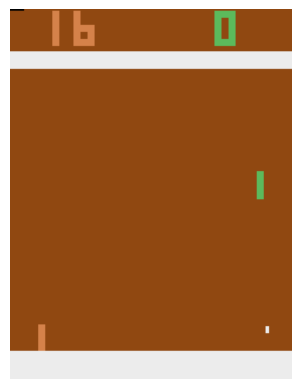

In [22]:
observation, info = env.reset()
policy.init_game(observation)

plt.ion()
plt.axis('off')
img = plt.imshow(env.render())

with tqdm(total=10000) as pbar:
    while True:
        try:
            action = policy(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            #render(env)
            policy.update(observation, reward, terminated, truncated, info, pbar)

            if terminated or truncated:
                pbar.update()
                observation, info = env.reset()
                policy.init_game(observation)
                
        except KeyboardInterrupt:
            break
env.close()

In [ ]:
policy.save("ac_model.pt")